In [ ]:
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.utils import class_weight



In [ ]:
tf.__version__

'2.19.0'

In [ ]:
!python --version

Python 3.12.12


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
#extracting train data
#only  remove the comment and run this code once

'''
with zipfile.ZipFile("/content/train.zip", 'r') as zip_ref:
    zip_ref.extractall("train_dataset")

#extracting train data
with zipfile.ZipFile("/content/test.zip", 'r') as zip_ref:
    zip_ref.extractall("test_dataset")
'''


'\nwith zipfile.ZipFile("/content/train.zip", \'r\') as zip_ref:\n    zip_ref.extractall("train_dataset")\n\n#extracting train data \nwith zipfile.ZipFile("/content/test.zip", \'r\') as zip_ref:\n    zip_ref.extractall("test_dataset")\n'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train_dataset/train", # keras هيضبط ال classes  لوحده  dw
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)




Found 836 files belonging to 2 classes.
Using 669 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train_dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 836 files belonging to 2 classes.
Using 167 files for validation.


In [ ]:
import os

train_dir = "/content/train_dataset/train"
classes = os.listdir(train_dir)
print("Classes:", classes)

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    n_images = len(os.listdir(class_path))
    print(f"Class '{cls}' has {n_images} images")


Classes: ['brain_glioma', 'brain_menin']
Class 'brain_glioma' has 800 images
Class 'brain_menin' has 36 images


In [ ]:
# meningitis data set is very small this indicates a class imbalance in our dataset
# so we will apply weights to each class to try and handle this

y_train = []

for images, labels in train_ds:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.524294670846395), 1: np.float64(10.790322580645162)}


In [ ]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [ ]:

base = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False


In [ ]:
model = models.Sequential([
    data_aug,
    layers.Lambda(tf.keras.applications.resnet.preprocess_input),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]


In [ ]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks ,
    class_weight=class_weights
)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6167 - loss: 0.7199

21/21 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.6152 - loss: 0.7186 - val_accuracy: 0.7425 - val_loss: 0.6065 - learning_rate: 1.0000e-04
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8391 - loss: 0.4242

21/21 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step - accuracy: 0.8403 - loss: 0.4256 - val_accuracy: 0.8024 - val_loss: 0.5229 - learning_rate: 1.0000e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7836 - loss: 0.3556

21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.7858 - loss: 0.3547 - val_accuracy: 0.9162 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.9016 - loss: 0.3445 - val_accuracy: 0.9042 - val_loss: 0.2347 - learning_rate: 1.0000e-04
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8946 - loss: 0.3179

21/21 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.8947 - loss: 0.3155 - val_accuracy: 0.9162 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.9140 - loss: 0.2721 - val_accuracy: 0.9102 - val_loss: 0.2087 - learning_rate: 1.0000e-04
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9298 - loss: 0.2333

21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.9295 - loss: 0.2319 - val_accuracy: 0.9102 - val_loss: 0.1750 - learning_rate: 1.0000e-04
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9323 - loss: 0.2042

21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.9324 - loss: 0.2032 - val_accuracy: 0.9102 - val_loss: 0.1616 - learning_rate: 1.0000e-04
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.9304 - loss: 0.1681 - val_accuracy: 0.9162 - val_loss: 0.1662 - learning_rate: 1.0000e-04
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9371 - loss: 0.1887

21/21 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.9363 - loss: 0.1886 - val_accuracy: 0.9222 - val_loss: 0.1437 - learning_rate: 1.0000e-04


In [ ]:

base.trainable = True
for layer in base.layers[:140]:
    layer.trainable = False


In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:

model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8640 - loss: 0.2443

21/21 ━━━━━━━━━━━━━━━━━━━━ 215s 10s/step - accuracy: 0.8653 - loss: 0.2440 - val_accuracy: 0.9760 - val_loss: 0.0834 - learning_rate: 1.0000e-05
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 0.9156 - loss: 0.1584 - val_accuracy: 0.9760 - val_loss: 0.0859 - learning_rate: 1.0000e-05
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - accuracy: 0.9365 - loss: 0.1209 - val_accuracy: 0.9820 - val_loss: 0.0839 - learning_rate: 1.0000e-05
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9479 - loss: 0.0990

21/21 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - accuracy: 0.9480 - loss: 0.0992 - val_accuracy: 0.9880 - val_loss: 0.0796 - learning_rate: 2.0000e-06
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9478 - loss: 0.0977

21/21 ━━━━━━━━━━━━━━━━━━━━ 182s 9s/step - accuracy: 0.9481 - loss: 0.0984 - val_accuracy: 0.9820 - val_loss: 0.0775 - learning_rate: 2.0000e-06


In [ ]:
loss, acc = model.evaluate(train_ds)
print("Accuracy:", acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9857 - loss: 0.0309
Accuracy: 0.9895366430282593


In [ ]:

loss, acc = model.evaluate(val_ds)
print("Accuracy:", acc)


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9871 - loss: 0.0639
Accuracy: 0.9820359349250793


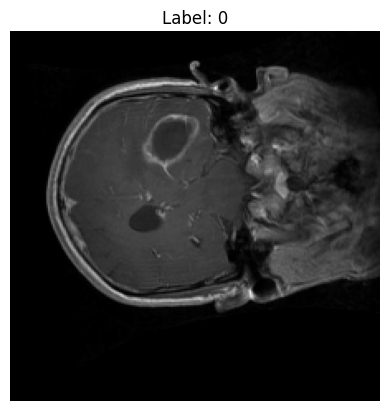

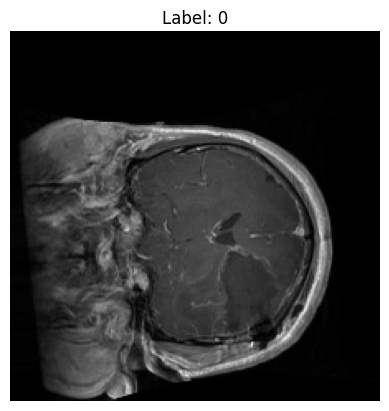

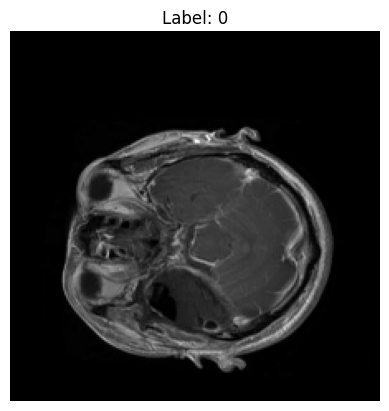

In [ ]:
images, labels = next(iter(train_ds))

for i in range(3):  # نعرض 3 صور بس
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Label: {labels[i].numpy()}")
    plt.axis("off")
    plt.show()


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/test_dataset/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 210 files belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9651 - loss: 0.0779
Test accuracy: 0.976190447807312


In [ ]:
# our train , validation and test accuricies are very close to each other
#this is a good indicator that there is no significant overfitting
#we will discuss more on that and other down below

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.squeeze())

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
y_pred_labels = (np.array(y_pred) >= 0.5).astype(int)


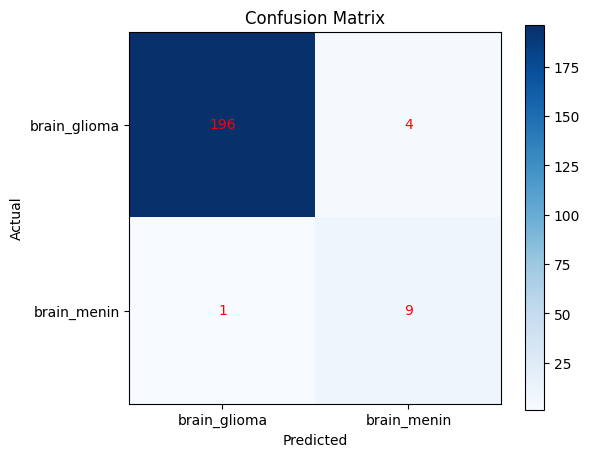

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], test_ds.class_names)
plt.yticks([0,1], test_ds.class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')

plt.show()


In [ ]:
print(classification_report(
    y_true,
    y_pred_labels,
    target_names=test_ds.class_names

))


              precision    recall  f1-score   support

brain_glioma       0.99      0.98      0.99       200
 brain_menin       0.69      0.90      0.78        10

    accuracy                           0.98       210
   macro avg       0.84      0.94      0.89       210
weighted avg       0.98      0.98      0.98       210



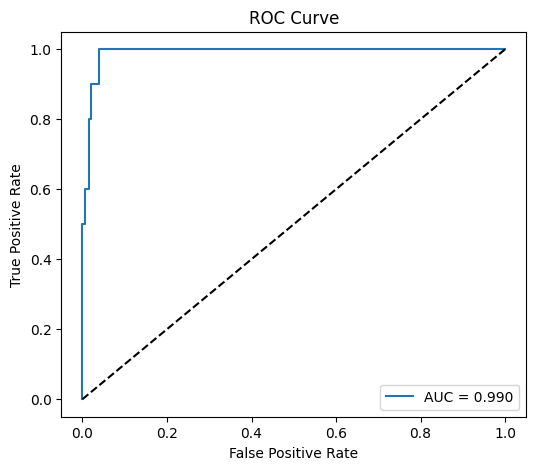

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


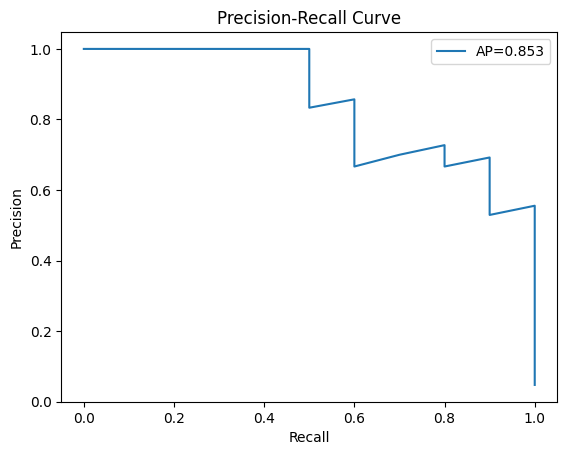

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true = np.array(y_true)
y_scores = np.array(y_pred)  # sigmoid outputs

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
